# UAS BIG DATA
**Recency, Frequency, Monetary**
**Nim : 1182002002**
**Nama : Febby Novanti Azhara**

# Import Library

In [122]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime as dt
import numpy as np

# Importa Data

In [123]:
dataTxD = pd.read_csv('../input/uas-rfm/UAS_RFM.csv', sep=';', parse_dates=['TrxDate'])
dataTxD.head()

,CardID,TrxDate,Amount
0,1000152,2021-02-22,670970
1,1000158,2021-12-06,396433
2,1000156,2021-05-24,114270
3,1000115,2021-05-30,420477
4,1000164,2021-06-23,361661


In [124]:
dataTxD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   CardID   199 non-null    int64         
 1   TrxDate  199 non-null    datetime64[ns]
 2   Amount   199 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 KB


**Melihat tanggal transaksi terbaru dan terlama**

In [125]:
print(dataTxD['TrxDate'].min(), dataTxD['TrxDate'].max())

2021-01-02 00:00:00 2021-12-06 00:00:00


**Menghitung data dari tanggal 2021-12-10**

In [126]:
now = dt.datetime(2021,12,10)
dataTxD['hist']=now - dataTxD['TrxDate']
dataTxD['hist'].astype('timedelta64[D]')
dataTxD['hist']=dataTxD['hist'] / np.timedelta64(1, 'D')
dataTxD.head(10)

,CardID,TrxDate,Amount,hist
0,1000152,2021-02-22,670970,291.0
1,1000158,2021-12-06,396433,4.0
2,1000156,2021-05-24,114270,200.0
3,1000115,2021-05-30,420477,194.0
4,1000164,2021-06-23,361661,170.0
5,1000136,2021-05-05,246831,219.0
6,1000147,2021-12-04,794326,6.0
7,1000118,2021-03-18,237591,267.0
8,1000167,2021-05-16,169632,208.0
9,1000160,2021-01-04,370557,340.0


In [127]:
dataTxD=dataTxD[dataTxD['hist'] < 350]
dataTxD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 198
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   CardID   199 non-null    int64         
 1   TrxDate  199 non-null    datetime64[ns]
 2   Amount   199 non-null    int64         
 3   hist     199 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 7.8 KB


**Membuat RFM Table**

In [128]:
RFMTab = dataTxD.groupby('CardID').agg({'hist': lambda x:x.max(), # Recency
                                        'CardID': lambda x: len(x), # Frequency
                                        'Amount': lambda x: x.sum()}) # Monetary Value

RFMTab.rename(columns={'hist': 'recency', 
                         'CardID': 'frequency', 
                         'Amount': 'monetary'}, inplace=True)
RFMTab.head(10)

,recency,frequency,monetary
CardID,,,
1000101,98.0,1,157999
1000102,341.0,3,1750216
1000103,338.0,1,219348
1000104,329.0,2,1070546
1000105,321.0,5,3697893
1000106,324.0,2,1112120
1000107,297.0,3,1027622
1000108,298.0,3,644940
1000109,234.0,2,1119154


**Membuat menjadi 3 kategori dengan quartile**

In [129]:
quartiles = RFMTab.quantile(q=[0.40,0.80,0.120])
quartiles

,recency,frequency,monetary
0.40,291.0,2.0,979541.0
0.80,328.0,4.0,2227265.0
0.12,218.4,1.0,466641.8


**Recency Quartile**

In [130]:
def RClass(x,p,d):
    if x <= d[p][0.40]:
        return 4
    elif x <= d[p][0.80]:
        return 3
    elif x <= d[p][0.120]: 
        return 2
    else:
        return 1

**Frequency dan Monetary Quartile**

In [131]:
def FMClass(x,p,d):
    if x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.80]:
        return 2
    elif x <= d[p][0.120]: 
        return 3
    else:
        return 4 

In [132]:
rfmSeg = RFMTab
rfmSeg['R_Quartile'] = rfmSeg['recency'].apply(RClass, args=('recency',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['frequency'].apply(FMClass, args=('frequency',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['monetary'].apply(FMClass, args=('monetary',quartiles,))

In [133]:
rfmSeg['RFMClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)
rfmSeg.head(10)

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
CardID,,,,,,,
1000101,98.0,1,157999,4,1,1,411
1000102,341.0,3,1750216,1,2,2,122
1000103,338.0,1,219348,1,1,1,111
1000104,329.0,2,1070546,1,1,2,112
1000105,321.0,5,3697893,3,4,4,344
1000106,324.0,2,1112120,3,1,2,312
1000107,297.0,3,1027622,3,2,2,322
1000108,298.0,3,644940,3,2,1,321
1000109,234.0,2,1119154,4,1,2,412


In [134]:
rfmSeg.groupby('RFMClass').size().sort_values(ascending=False)[:10]

RFMClass
411    16
322     8
311     7
344     7
122     6
422     5
412     4
112     3
111     3
324     2
dtype: int64

In [135]:
rfmSeg[rfmSeg['RFMClass']=='111']

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
CardID,,,,,,,
1000103,338.0,1,219348,1,1,1,111
1000160,340.0,2,827777,1,1,1,111
1000170,330.0,2,927142,1,1,1,111


**Total Class**

In [136]:
rfmSeg['Total Class'] = rfmSeg['R_Quartile'] + rfmSeg['F_Quartile'] + \
rfmSeg['M_Quartile']


rfmSeg.head(10)

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Class
CardID,,,,,,,,
1000101,98.0,1,157999,4,1,1,411,6
1000102,341.0,3,1750216,1,2,2,122,5
1000103,338.0,1,219348,1,1,1,111,3
1000104,329.0,2,1070546,1,1,2,112,4
1000105,321.0,5,3697893,3,4,4,344,11
1000106,324.0,2,1112120,3,1,2,312,6
1000107,297.0,3,1027622,3,2,2,322,7
1000108,298.0,3,644940,3,2,1,321,6
1000109,234.0,2,1119154,4,1,2,412,7


In [137]:
rfmSeg.groupby('Total Class').size().sort_values(ascending=False)[:10]

Total Class
6     20
7     14
5     13
11     7
8      5
3      3
4      3
9      3
12     2
10     1
dtype: int64

In [176]:
def segment_me(df):
    if df['Total Class'] == 3:
        return 'Best Customers'
    elif (df['Total Class'] == 5):
        return 'Almost Lost'
    elif (df['Total Class'] == 6):
        return 'Lost Customers'
    elif (df['F_Quartile'] == 1):
        return 'Loyal Customers'
    elif (df['M_Quartile'] == 1):
        return 'Big Spenders'
    else:
        return 'Lost Cheap Customers'

In [177]:
rfmSeg['Desc'] = rfmSeg.apply(segment_me, axis=1)
rfmSeg[['recency', 'frequency', 'monetary', 'R_Quartile','F_Quartile', 'M_Quartile', 'RFMClass', 'Total Class','Desc']].sample(10)

,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass,Total Class,Desc
CardID,,,,,,,,,
1000114,291.0,4,2227265,4,2,2,422,8,Lost Cheap Customers
1000133,295.0,3,1375713,3,2,2,322,7,Lost Cheap Customers
1000104,329.0,2,1070546,1,1,2,112,4,Loyal Customers
1000119,290.0,2,1520873,4,1,2,412,7,Loyal Customers
1000156,240.0,2,479510,4,1,1,411,6,Lost Customers
1000106,324.0,2,1112120,3,1,2,312,6,Lost Customers
1000167,208.0,3,620489,4,2,1,421,7,Big Spenders
1000115,327.0,4,1834839,3,2,2,322,7,Lost Cheap Customers
1000135,317.0,3,750986,3,2,1,321,6,Lost Customers


In [178]:
rfmSeg.groupby('Desc').size().sort_values(ascending=True)

Desc
Big Spenders             1
Best Customers           3
Loyal Customers          7
Almost Lost             13
Lost Customers          20
Lost Cheap Customers    27
dtype: int64

<AxesSubplot:xlabel='Desc'>

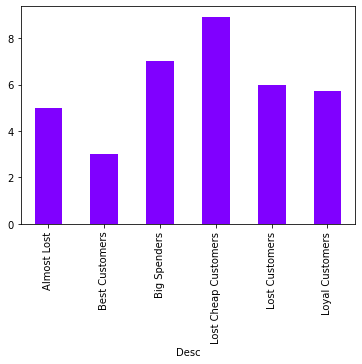

In [179]:
rfmSeg.groupby('Desc').agg('Total Class').mean().plot(kind='bar', colormap='rainbow')